# Implementação da arquitetura CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.Resize(size = (224,224)), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
train = '1Amostragem/train'
test = '1Amostragem/test'

In [5]:
train_dataset = datasets.ImageFolder(train,transform = transform)
test_dataset = datasets.ImageFolder(test,transform = transform)

In [6]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 50
    Root location: 1Amostragem/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:
train_dataset.classes

['normal', 'pneumonia']

In [8]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 50
    Root location: 1Amostragem/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [9]:
trainloader = DataLoader(train_dataset,batch_size = 64,shuffle = True)
testloader = DataLoader(test_dataset,batch_size = 64,shuffle = True)

In [10]:
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

torch.Size([50, 3, 224, 224])
torch.Size([50])


In [11]:
from torch.autograd import Variable
for i, (images,labels) in enumerate(trainloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

In [12]:
class Model(nn.Module):
    def __init__(self, num_classes=2):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(384)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = nn.Linear(256 * 14 * 14, 1000)
        self.bn6 = nn.BatchNorm1d(1000)
        self.linear2 = nn.Linear(1000, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.bn6(self.linear1(x)))
        x = self.linear2(x)
        return x

In [16]:
model = Model(num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=50176, out_features=1000, bias=True)

In [18]:
num_epochs = 500
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0
    
    for images, labels in trainloader:     
        images, labels = images.to(device), labels.to(device)      
        optimizer.zero_grad()      
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()      
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)
    
    print(f"Epoca {epoch + 1}/{num_epochs} - Perda no treinamento: {avg_train_loss:.4f}")
    
    # Teste
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(testloader)
    test_losses.append(avg_test_loss)
    accuracy = correct / total * 100
    
    print(f"Epoca {epoch + 1}/{num_epochs} - Perda no teste: {avg_test_loss:.4f}, Metrica de avaliacao (Accuracy): {accuracy:.2f}%")

Epoca 1/500 - Perda no treinamento: 0.7046
Epoca 1/500 - Perda no teste: 1.2616, Metrica de avaliacao (Accuracy): 50.00%
Epoca 2/500 - Perda no treinamento: 0.0861
Epoca 2/500 - Perda no teste: 1.8155, Metrica de avaliacao (Accuracy): 46.00%
Epoca 3/500 - Perda no treinamento: 1.4869
Epoca 3/500 - Perda no teste: 3.6105, Metrica de avaliacao (Accuracy): 50.00%
Epoca 4/500 - Perda no treinamento: 0.0367
Epoca 4/500 - Perda no teste: 2.2818, Metrica de avaliacao (Accuracy): 54.00%
Epoca 5/500 - Perda no treinamento: 0.0468
Epoca 5/500 - Perda no teste: 1.5066, Metrica de avaliacao (Accuracy): 58.00%
Epoca 6/500 - Perda no treinamento: 0.0299
Epoca 6/500 - Perda no teste: 1.1020, Metrica de avaliacao (Accuracy): 62.00%
Epoca 7/500 - Perda no treinamento: 0.0267
Epoca 7/500 - Perda no teste: 0.9133, Metrica de avaliacao (Accuracy): 68.00%
Epoca 8/500 - Perda no treinamento: 0.0239
Epoca 8/500 - Perda no teste: 0.9894, Metrica de avaliacao (Accuracy): 68.00%
Epoca 9/500 - Perda no treinamen

In [20]:
predicted

tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1])

In [21]:
labels

tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1])

In [32]:
epoch

499

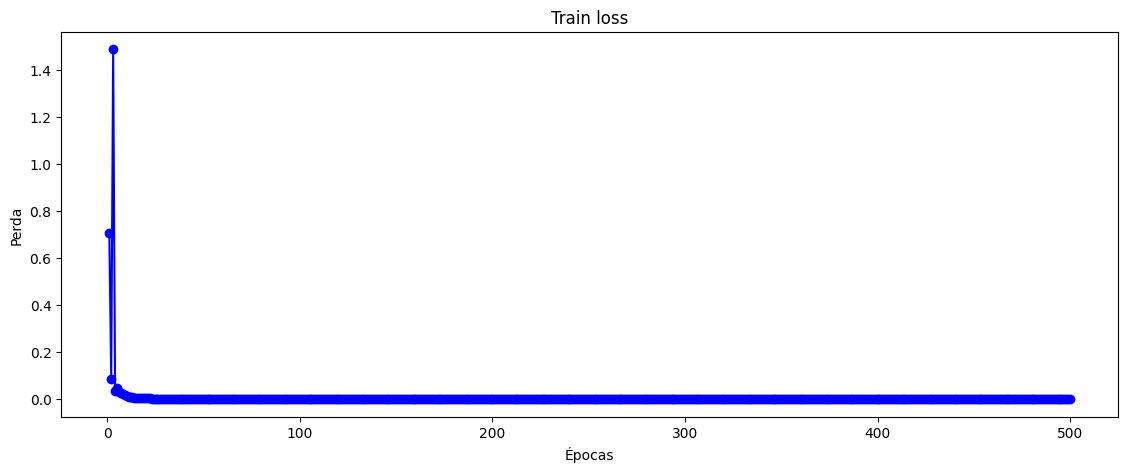

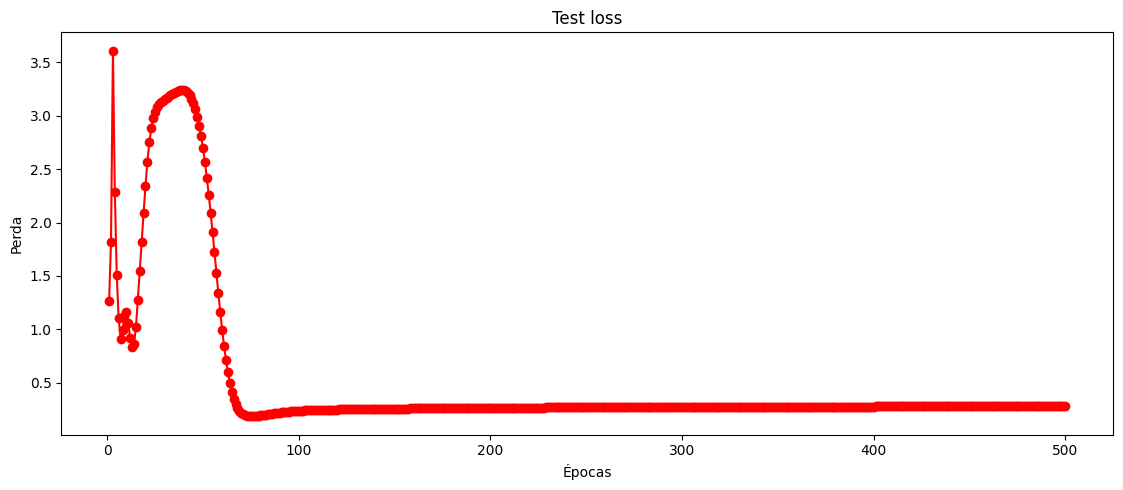

In [48]:
steps = range(1, 501)

plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, train_losses, 'bo-')
plt.title('Train loss')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.figure(figsize=(22, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, test_losses, 'ro-')
plt.title('Test loss')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.tight_layout()
plt.show()

# Métricas de avaliação

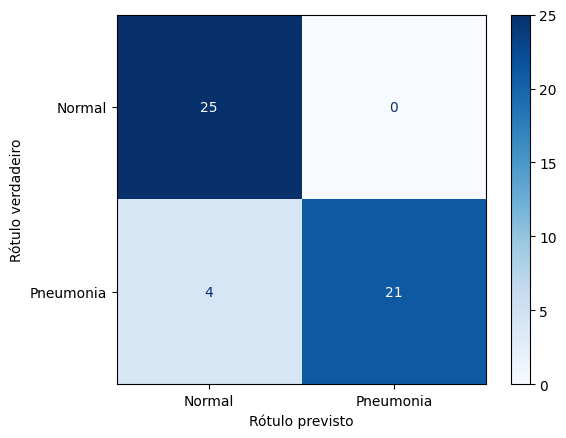

In [22]:
cm = confusion_matrix(labels, predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.show()

In [23]:
accuracy = accuracy_score(labels, predicted)
print(f"Acurácia: {accuracy}")

Acurácia: 0.92


In [24]:
precision = precision_score(labels, predicted, average='weighted')
print(f"Precisão: {precision}")

Precisão: 0.9310344827586207


In [25]:
recall = recall_score(labels, predicted, average='weighted')
print(f"Recall: {recall}")

Recall: 0.92


In [26]:
f1 = f1_score(labels, predicted, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.9194847020933977


AUC-ROC: 0.9199999999999999


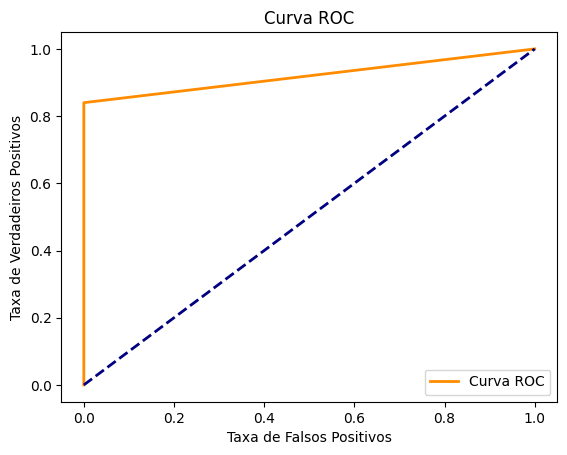

In [49]:
if len(train_dataset.classes) == 2:
    auc_roc = roc_auc_score(labels, predicted)
    print(f"AUC-ROC: {auc_roc}")

    fpr, tpr, _ = roc_curve(labels, predicted)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()